In [12]:
from datetime import datetime, timedelta

import pandas as pd
import duckdb

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [13]:
# Conecta abrindo / criando um arquivo
conn2 = duckdb.connect()

In [14]:
# Gravação no formato Parquet
df_transacao = conn2.execute("""
    SELECT
    *
    FROM
    read_parquet('./dados/hackathon_2025_templates/part-00000-tid-5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8-4-1-c000.snappy.parquet')
""").fetchdf()
df_transacao.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758


In [15]:
df_transacao.shape

(6560698, 11)

In [16]:
# 1. Carregar os dados

# Copia apenas 1000 registros e já renomeia as colunas
df_work = df_transacao.loc[:99999,['transaction_date', 'internal_store_id', 'internal_product_id', 'quantity']].rename(
    columns={
        'transaction_date': 'Data',
        'internal_store_id': 'PDV',
        'internal_product_id': 'Produto',
        'quantity': 'Quantidade'
    }
).copy()

# Remove registros com data nula
#df_work = df_work.dropna(subset=['Data'])
df_work['Data'] = pd.to_datetime(df_work['Data'], errors='coerce')
df_work['Quantidade'] = df_work['Quantidade'].astype(int)
df_work.describe()
df_work.info()
#df_work.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Data        100000 non-null  datetime64[us]
 1   PDV         100000 non-null  object        
 2   Produto     100000 non-null  object        
 3   Quantidade  100000 non-null  int64         
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 3.1+ MB


In [17]:
# Agregação: Exemplo de soma de vendas por mês e região
dados_agrupados = df_work.groupby(['Data', 'PDV','Produto']).agg({'Quantidade': 'sum'}).reset_index()


In [18]:
# Codificação de variáveis categóricas
dados_agrupados = pd.get_dummies(dados_agrupados, columns=['PDV', 'Produto'], drop_first=True)


In [19]:
# Separação entre variáveis independentes (X) e dependente (y)
X = dados_agrupados.drop('Quantidade', axis=1)
y = dados_agrupados['Quantidade']


In [20]:
# 3. Divisão dos Dados e Treinamento do Modelo Python
# Divisão em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Treinamento do modelo preditivo
modelo = RandomForestRegressor(random_state=42)
# O erro ocorre porque a coluna 'Data' está presente em X_treino e X_teste,
#  mas RandomForestRegressor não lida com datas.
# Solução: remova a coluna 'Data' de X_treino e X_teste antes de treinar o modelo.

X_treino_sem_data = X_treino.drop('Data', axis=1)
X_teste_sem_data = X_teste.drop('Data', axis=1)

modelo.fit(X_treino_sem_data, y_treino)


In [ ]:
# 4. Avaliação do Modelo Python
# Previsões
y_pred = modelo.predict(X_teste_sem_data)


In [ ]:
# Avaliação do desempenho
rmse = np.sqrt(mean_squared_error(y_teste, y_pred))
print(f'Erro Quadrático Médio (RMSE): {rmse}')


Erro Quadrático Médio (RMSE): 228.3552009025646


In [ ]:
#5. Visualização (Opcional) Python
import matplotlib.pyplot as plt


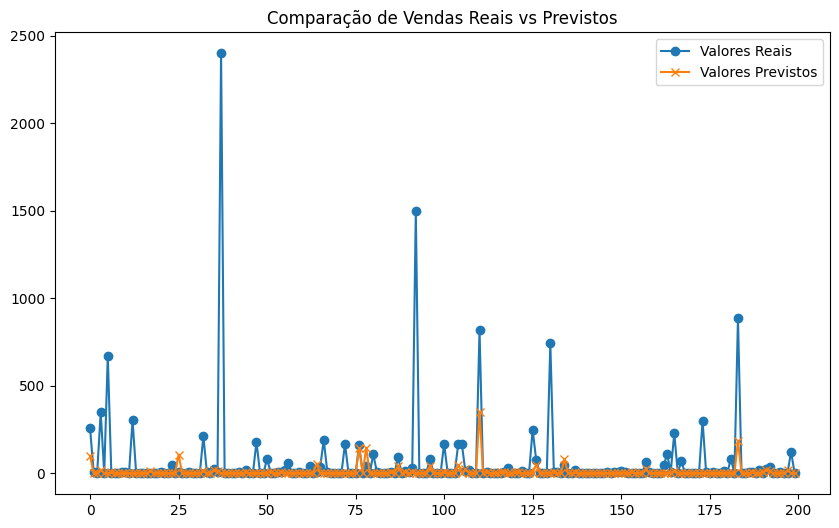

In [ ]:
# Comparação entre valores reais e previstos
plt.figure(figsize=(10, 6))
plt.plot(y_teste.values, label='Valores Reais', marker='o')
plt.plot(y_pred, label='Valores Previstos', marker='x')
plt.legend()
plt.title('Comparação de Vendas Reais vs Previstos')
plt.show()


In [ ]:
conn2.close()